# GA Evaluation Across Weather Scenarios

This notebook:
1. Generates 20 synthetic weather scenarios (normal to extreme)
2. Runs GA optimization on the baseline (historical) weather to find the optimal fixed strategy
3. Evaluates that fixed strategy on all 20 scenarios
4. Saves results for comparison with MPC

In [49]:
# Import necessary modules
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_bounds import DesignSpaceBounds
from core.ga.ga_params import GeneticAlgorithmParams
from core.ga.ga import GeneticAlgorithm
from core.ga.ga_member import Member
from core.ga.ga_population import Population

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.weather.stochastic_weather import (
    StochasticWeatherGenerator,
    WeatherScenario,
    get_default_scenarios,
    scenarios_to_dataframe
)

from core.plotting.plotting import *

## 1. Generate Weather Scenarios

In [50]:
# Load historical weather data
historical_df = pd.read_csv('../../io/inputs/hourly_prcp_rad_temp_iowa.csv')
print(f"Historical data shape: {historical_df.shape}")
print(f"Columns: {historical_df.columns.tolist()}")

Historical data shape: (2928, 3)
Columns: ['Hourly Precipitation (in)', 'Hourly Radiation (W/m2)', 'Temperature (C)']


In [51]:
# Create weather generator with fixed seed for reproducibility
generator = StochasticWeatherGenerator(historical_df, seed=42)

# Get default scenarios (20 scenarios from normal to extreme)
scenarios = get_default_scenarios()

# Display scenario summary
scenario_summary = scenarios_to_dataframe(scenarios)
print("Weather Scenarios Summary:")
print(scenario_summary.to_string())

Weather Scenarios Summary:
                    name  precip_scale  temp_offset  noise_std  n_drought_events  n_heatwave_events  extremity_index
0               normal_1          1.00          0.0       0.03                 0                  0             0.00
1               normal_2          0.95          0.5       0.03                 0                  0             0.20
2               normal_3          1.05         -0.5       0.03                 0                  0             0.20
3               normal_4          0.90          1.0       0.05                 0                  0             0.40
4               normal_5          1.10         -1.0       0.05                 0                  0             0.40
5           moderate_dry          0.75          1.5       0.05                 0                  0             0.80
6           moderate_wet          1.25         -1.0       0.05                 0                  0             0.70
7          moderate_warm          0.9

In [52]:
# Generate all weather scenarios
weather_data = generator.generate_batch(scenarios)

# Add the original historical as "baseline"
weather_data['baseline'] = historical_df.copy()

print(f"Generated {len(weather_data)} weather scenarios")
for name in weather_data:
    df = weather_data[name]
    print(f"  {name}: precip_total={df['Hourly Precipitation (in)'].sum():.1f} in, "
          f"temp_mean={df['Temperature (C)'].mean():.1f} C")

Generated 21 weather scenarios
  normal_1: precip_total=31.5 in, temp_mean=22.8 C
  normal_2: precip_total=29.9 in, temp_mean=23.3 C
  normal_3: precip_total=33.0 in, temp_mean=22.3 C
  normal_4: precip_total=28.3 in, temp_mean=23.8 C
  normal_5: precip_total=34.6 in, temp_mean=21.8 C
  moderate_dry: precip_total=23.6 in, temp_mean=24.3 C
  moderate_wet: precip_total=39.3 in, temp_mean=21.8 C
  moderate_warm: precip_total=28.3 in, temp_mean=25.3 C
  moderate_cool: precip_total=34.6 in, temp_mean=20.8 C
  moderate_variable: precip_total=31.5 in, temp_mean=22.8 C
  mild_drought: precip_total=17.8 in, temp_mean=23.8 C
  summer_drought: precip_total=21.3 in, temp_mean=24.8 C
  early_drought: precip_total=19.1 in, temp_mean=24.3 C
  late_drought: precip_total=18.1 in, temp_mean=23.8 C
  wet_year: precip_total=44.1 in, temp_mean=21.3 C
  cool_wet: precip_total=40.9 in, temp_mean=20.3 C
  heat_stress: precip_total=25.2 in, temp_mean=25.1 C
  multiple_heatwaves: precip_total=26.7 in, temp_mean

In [53]:
# Save weather scenarios for MPC notebook to use
os.makedirs('weather_scenario_results', exist_ok=True)

with open('weather_scenario_results/weather_scenarios.pkl', 'wb') as f:
    pickle.dump(weather_data, f)

with open('weather_scenario_results/scenario_configs.pkl', 'wb') as f:
    pickle.dump(scenarios, f)

scenario_summary.to_csv('weather_scenario_results/scenario_summary.csv', index=False)
print("Weather scenarios saved.")

Weather scenarios saved.


## 2. Model and GA Parameters

In [54]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 1.0,  # hours/step
    simulation_hours = 2900, # hours
    verbose          = False
)

In [55]:
# Set ModelCarryingCapacities (corn defaults)
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [56]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [57]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [58]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours,
    A0=carrying_capacities.kA/model_params.simulation_hours,
    N0=carrying_capacities.kN/model_params.simulation_hours,
    c0=carrying_capacities.kc/model_params.simulation_hours,
    P0=carrying_capacities.kP/model_params.simulation_hours
)

In [59]:
# Set typical disturbances
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

In [60]:
# Set design space bounds
lower_bounds = np.array([12, 0, 24, 0])      # [irr_freq, irr_amt, fert_freq, fert_amt]
upper_bounds = np.array([2900, 10, 2900, 700])

bounds = DesignSpaceBounds(
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds
)

In [61]:
# GA parameters
ga_params = GeneticAlgorithmParams(
    num_parents     = 16,
    num_kids        = 16,
    num_generations = 100,
    num_members     = 128,
)

## 3. Run GA Optimization on Baseline Weather

Find the optimal *fixed* strategy using the historical (baseline) weather.

In [62]:
# Create disturbances from baseline weather
baseline_weather = weather_data['baseline']
baseline_disturbances = ModelDisturbances(
    precipitation = baseline_weather['Hourly Precipitation (in)'].to_numpy(),
    radiation     = baseline_weather['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = baseline_weather['Temperature (C)'].to_numpy()
)

In [63]:
# Create GeneticAlgorithm object
ga = GeneticAlgorithm(
    bounds               = bounds,
    ga_params            = ga_params,
    model_params         = model_params,
    carrying_capacities  = carrying_capacities,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    disturbances         = baseline_disturbances,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities
)

In [64]:
# Run GA with C++ evaluator for speed
print("Running GA optimization on baseline weather...")
t_start = time.time()

ga_result = ga.run_with_cpp()

t_end = time.time()
print(f"GA optimization completed in {t_end - t_start:.1f} seconds")

Running GA optimization on baseline weather...
Time taken to evaluate population with C++ evaluator: 0.38623499870300293 seconds
Time taken to calculate costs for g=0: 0.3920857906341553 seconds
Generation 2 of 100
Time taken to breed kids for g=1: 0.00011706352233886719 seconds
Time taken to fill random members for g=1: 0.0011363029479980469 seconds
Time taken to evaluate population with C++ evaluator: 0.40188097953796387 seconds
Time taken to calculate costs for g=1: 0.40631985664367676 seconds
Lowest cost in generation 1: -911.99
Time taken to sort population for g=1: 4.696846008300781e-05 seconds
Generation 3 of 100
Time taken to breed kids for g=2: 9.799003601074219e-05 seconds
Time taken to fill random members for g=2: 0.001026153564453125 seconds
Time taken to evaluate population with C++ evaluator: 0.3765897750854492 seconds
Time taken to calculate costs for g=2: 0.38048410415649414 seconds
Lowest cost in generation 2: -912.33
Time taken to sort population for g=2: 3.1948089599

In [65]:
# Extract optimal fixed strategy
optimal_strategy = ga_result.final_population.values[0]  # best member
optimal_cost = ga_result.final_population.costs[0]

print(f"\nOptimal Fixed Strategy:")
print(f"  Irrigation frequency: {optimal_strategy[0]:.1f} hours (every {optimal_strategy[0]/24:.1f} days)")
print(f"  Irrigation amount:    {optimal_strategy[1]:.2f} inches")
print(f"  Fertilizer frequency: {optimal_strategy[2]:.1f} hours (every {optimal_strategy[2]/24:.1f} days)")
print(f"  Fertilizer amount:    {optimal_strategy[3]:.1f} lbs")
print(f"\nExpected revenue on baseline weather: ${-optimal_cost:.2f}")


Optimal Fixed Strategy:
  Irrigation frequency: 2872.0 hours (every 119.7 days)
  Irrigation amount:    0.29 inches
  Fertilizer frequency: 328.0 hours (every 13.7 days)
  Fertilizer amount:    45.6 lbs

Expected revenue on baseline weather: $1024.46


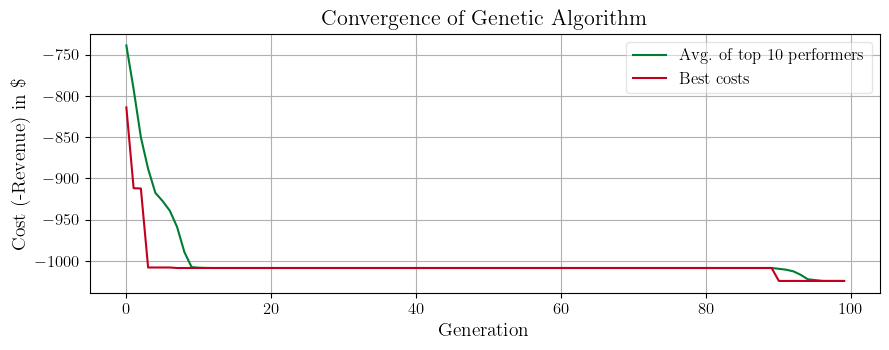

In [66]:
# Plot GA convergence
ga_result.plot_optimization_results()

In [67]:
# Save optimal strategy
with open('weather_scenario_results/ga_optimal_strategy.pkl', 'wb') as f:
    pickle.dump({
        'strategy': optimal_strategy,
        'baseline_cost': optimal_cost,
        'baseline_revenue': -optimal_cost
    }, f)

print("Optimal strategy saved.")

Optimal strategy saved.


## 4. Evaluate Fixed Strategy on All Weather Scenarios

The GA found one optimal strategy. Now we evaluate how that *fixed* strategy performs across all 20 weather scenarios.

In [68]:
# Evaluate optimal strategy on each weather scenario
ga_results = {}

# Get economic weights
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_height = ga_params.weight_height
weight_leaf_area = ga_params.weight_leaf_area
weight_irrigation = ga_params.weight_irrigation
weight_fertilizer = ga_params.weight_fertilizer

# Create model params with verbose=True for evaluation (to get state trajectories)
eval_model_params = ModelParams(
    dt               = model_params.dt,
    simulation_hours = model_params.simulation_hours,
    verbose          = True  # Enable CSV output for state trajectories
)

print("Evaluating fixed strategy on all scenarios...\n")

for scenario_name, weather_df in weather_data.items():
    # Create disturbances for this scenario
    scenario_disturbances = ModelDisturbances(
        precipitation = weather_df['Hourly Precipitation (in)'].to_numpy(),
        radiation     = weather_df['Hourly Radiation (W/m2)'].to_numpy(),
        temperature   = weather_df['Temperature (C)'].to_numpy()
    )
    
    # Create member with optimal strategy (using verbose model params)
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = scenario_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = eval_model_params,  # Use verbose params
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values               = optimal_strategy
    )
    
    # Evaluate (this writes to output_get_cost.csv when verbose=True)
    cost = member.get_cost()
    revenue = -cost
    
    # Read detailed results from CSV
    output = pd.read_csv('output_get_cost.csv')
    P_final = output['P'].iloc[-1]
    h_final = output['h'].iloc[-1]
    A_final = output['A'].iloc[-1]
    
    # Calculate irrigation and fertilizer totals from strategy
    simulation_hours = model_params.simulation_hours
    n_irrigations = int(simulation_hours / optimal_strategy[0])
    n_fertilizations = int(simulation_hours / optimal_strategy[2])
    total_irrigation = n_irrigations * optimal_strategy[1]
    total_fertilizer = n_fertilizations * optimal_strategy[3]
    
    ga_results[scenario_name] = {
        'revenue': revenue,
        'cost': cost,
        'fruit_biomass': P_final,
        'height': h_final,
        'leaf_area': A_final,
        'total_irrigation': total_irrigation,
        'total_fertilizer': total_fertilizer,
        'precip_total': weather_df['Hourly Precipitation (in)'].sum(),
        'temp_mean': weather_df['Temperature (C)'].mean()
    }
    
    print(f"{scenario_name:25s}: Revenue=${revenue:7.2f}, Fruit={P_final:.3f}kg")

Evaluating fixed strategy on all scenarios...

normal_1                 : Revenue=$1024.68, Fruit=0.235kg
normal_2                 : Revenue=$1033.63, Fruit=0.237kg
normal_3                 : Revenue=$ 988.58, Fruit=0.228kg
normal_4                 : Revenue=$1019.75, Fruit=0.234kg
normal_5                 : Revenue=$ 946.28, Fruit=0.219kg
moderate_dry             : Revenue=$ 918.99, Fruit=0.214kg
moderate_wet             : Revenue=$ 884.07, Fruit=0.206kg
moderate_warm            : Revenue=$ 972.96, Fruit=0.226kg
moderate_cool            : Revenue=$ 899.53, Fruit=0.211kg
moderate_variable        : Revenue=$1023.34, Fruit=0.235kg
mild_drought             : Revenue=$ 799.72, Fruit=0.190kg
summer_drought           : Revenue=$ 855.86, Fruit=0.202kg
early_drought            : Revenue=$ 810.69, Fruit=0.192kg
late_drought             : Revenue=$ 825.70, Fruit=0.195kg
wet_year                 : Revenue=$ 779.15, Fruit=0.185kg
cool_wet                 : Revenue=$ 789.15, Fruit=0.188kg
heat_stre

In [69]:
# Convert to DataFrame
ga_results_df = pd.DataFrame(ga_results).T
ga_results_df.index.name = 'scenario'
ga_results_df = ga_results_df.reset_index()

# Add extremity index
scenario_configs = {s.name: s for s in scenarios}
ga_results_df['extremity'] = ga_results_df['scenario'].apply(
    lambda x: scenario_configs[x].extremity_index() if x in scenario_configs else 0.0
)

print("\nGA Results Summary:")
print(ga_results_df.to_string())


GA Results Summary:
                scenario      revenue         cost  fruit_biomass    height  leaf_area  total_irrigation  total_fertilizer  precip_total  temp_mean  extremity
0               normal_1  1024.684695 -1024.684695       0.235063  2.846069   0.613675          0.288841        364.449063     31.466250  22.817276       0.00
1               normal_2  1033.627468 -1033.627468       0.236725  2.885524   0.614441          0.288841        364.449063     29.892937  23.322283       0.20
2               normal_3   988.583198  -988.583198       0.228027  2.789027   0.600672          0.288841        364.449063     33.039562  22.321052       0.20
3               normal_4  1019.751983 -1019.751983       0.233634  2.913435   0.609350          0.288841        364.449063     28.319625  23.836749       0.40
4               normal_5   946.283347  -946.283347       0.219440  2.733840   0.590650          0.288841        364.449063     34.612875  21.831446       0.40
5           moderate_dry 

In [70]:
# Save GA evaluation results
with open('weather_scenario_results/ga_scenario_results.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

ga_results_df.to_csv('weather_scenario_results/ga_scenario_results.csv', index=False)

print("GA scenario results saved.")

GA scenario results saved.


## 5. Summary Statistics

In [71]:
# Summary statistics
print("GA Fixed Strategy Performance Across Scenarios")
print("=" * 50)
print(f"Mean revenue:   ${ga_results_df['revenue'].mean():.2f}")
print(f"Std revenue:    ${ga_results_df['revenue'].std():.2f}")
print(f"Min revenue:    ${ga_results_df['revenue'].min():.2f} ({ga_results_df.loc[ga_results_df['revenue'].idxmin(), 'scenario']})")
print(f"Max revenue:    ${ga_results_df['revenue'].max():.2f} ({ga_results_df.loc[ga_results_df['revenue'].idxmax(), 'scenario']})")
print(f"\nBaseline revenue: ${ga_results_df[ga_results_df['scenario'] == 'baseline']['revenue'].values[0]:.2f}")

GA Fixed Strategy Performance Across Scenarios
Mean revenue:   $882.73
Std revenue:    $144.70
Min revenue:    $491.50 (worst_case)
Max revenue:    $1033.63 (normal_2)

Baseline revenue: $1025.11


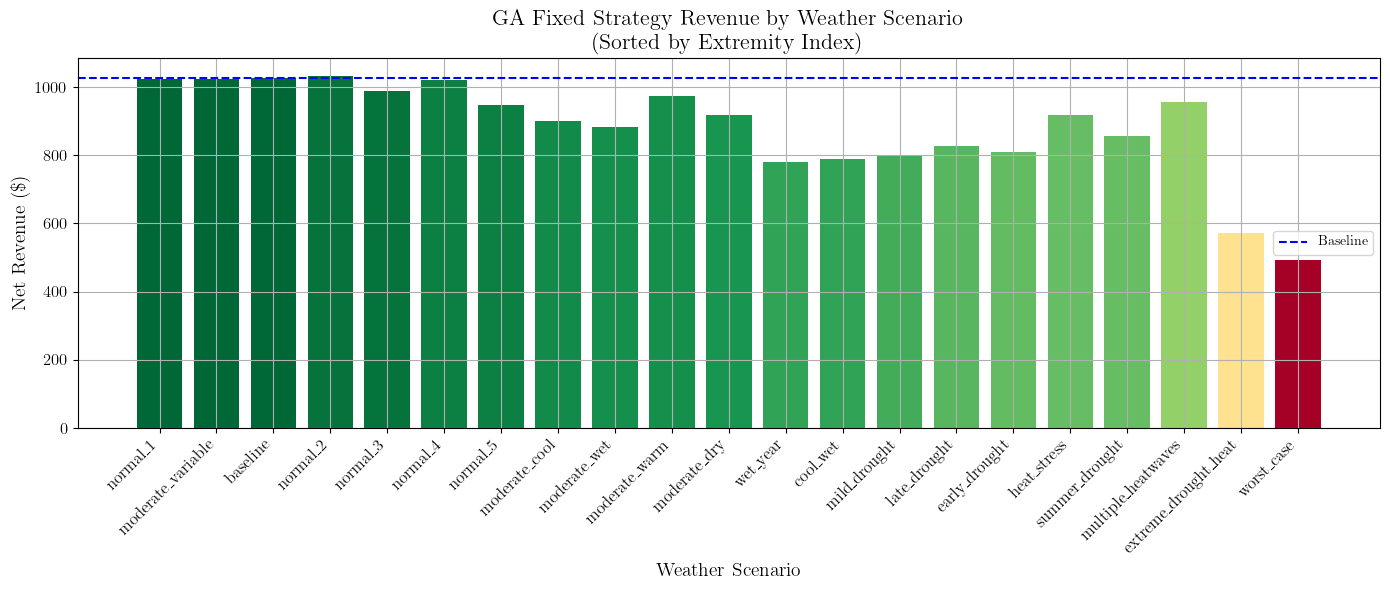

In [72]:
# Plot revenue by scenario
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 6))

# Sort by extremity for better visualization
df_sorted = ga_results_df.sort_values('extremity')

# Handle case where max extremity could be 0
max_extremity = df_sorted['extremity'].max()
if max_extremity > 0:
    colors = plt.cm.RdYlGn_r(df_sorted['extremity'] / max_extremity)
else:
    colors = ['#4CAF50'] * len(df_sorted)  # Default green if all extremity = 0

bars = ax.bar(range(len(df_sorted)), df_sorted['revenue'], color=colors)
ax.set_xticks(range(len(df_sorted)))
ax.set_xticklabels(df_sorted['scenario'], rotation=45, ha='right')
ax.set_xlabel('Weather Scenario')
ax.set_ylabel('Net Revenue (\\$)')  # Escape the dollar sign for LaTeX
ax.set_title('GA Fixed Strategy Revenue by Weather Scenario\n(Sorted by Extremity Index)')

# Get baseline revenue (handle case where baseline might not exist)
baseline_rows = ga_results_df[ga_results_df['scenario'] == 'baseline']
if len(baseline_rows) > 0:
    baseline_revenue = baseline_rows['revenue'].values[0]
    ax.axhline(baseline_revenue, color='blue', linestyle='--', label='Baseline')
    ax.legend()

plt.tight_layout()
plt.savefig('weather_scenario_results/ga_revenue_by_scenario.png', dpi=150)
plt.show()